In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!nvidia-smi

Mon Feb 10 07:33:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install tensorflow-gpu >> /dev/null

In [0]:
!pip install --upgrade grpcio >> /dev/null

In [0]:
!pip install tqdm  >> /dev/null

In [0]:
!pip install bert-for-tf2 >> /dev/null

In [0]:
!pip install sentencepiece >> /dev/null

In [0]:
!pip install kss >> /dev/null

In [0]:
import os
import kss
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/LAB/국민청원/petition_data_all_2019_01_09.csv'
data = pd.read_csv(data_path)

In [19]:
data.head()

,num,category,start-days,end-days,person,progress,title,count,petition_overview
0,21,안전/환경,2017-08-19,2017-11-17,kakao - ***,청원종료,스텔라 데이지호에 대한 제안입니다.,9,\n\t\t\t\t\t\t\t\t\t\t\t스텔라 데이지호에 대한 제안입니다. \n...
1,22,기타,2017-08-19,2017-11-17,kakao - ***,청원종료,비리제보처를 만들어주세요.,17,\n\t\t\t\t\t\t\t\t\t\t\t현 정부에 국민들이 가장 원하는 것은 부...
2,23,미래,2017-08-19,2017-09-03,kakao - ***,청원종료,제2의 개성공단,0,\n\t\t\t\t\t\t\t\t\t\t\t만일 하시는 대통령님 및 각 부처 장관님...
3,24,일자리,2017-08-19,2017-08-26,kakao - ***,청원종료,공공기관 무조건적인 정규직전환을 반대합니다.,53,\n\t\t\t\t\t\t\t\t\t\t\t현정부에서 정규직 일자리를 늘리는 것에 ...
4,25,미래,2017-08-19,2017-09-03,kakao - ***,청원종료,제2의 개성공단,0,\n\t\t\t\t\t\t\t\t\t\t\t만일 하시는 대통령님 및 각 부처 장관님...


In [0]:
data = data.drop_duplicates(subset='petition_overview', keep='last')

In [0]:
category_selected = ['정치개혁', '인권/성평등', '안전/환경', '교통/건축/국토', '외교/통일/국방']

In [22]:
df = data[data['category'].isin(category_selected)]
df.head()

,num,category,start-days,end-days,person,progress,title,count,petition_overview
0,21,안전/환경,2017-08-19,2017-11-17,kakao - ***,청원종료,스텔라 데이지호에 대한 제안입니다.,9,\n\t\t\t\t\t\t\t\t\t\t\t스텔라 데이지호에 대한 제안입니다. \n...
6,27,정치개혁,2017-08-19,2017-09-18,naver - ***,청원종료,김이수 헌재소장 임명 재고 건의,1,\n\t\t\t\t\t\t\t\t\t\t\t문 대통령님께 묻습니다 (2017. 8....
12,33,인권/성평등,2017-08-19,2017-11-17,naver - ***,청원종료,납득할 수 있는 장애 재판정을 받고 싶습니다.,15,\n\t\t\t\t\t\t\t\t\t\t\t안녕하십니까? 저는 경직형 양마비 뇌병변...
14,35,외교/통일/국방,2017-08-19,2017-08-26,kakao - ***,청원종료,문재인정부는 신한국형 페리프로세스가 작성했습니다.,0,\n\t\t\t\t\t\t\t\t\t\t\t문재인 대통령님 신한국형 페리프로세스 로...
15,36,인권/성평등,2017-08-19,2017-08-26,naver - ***,청원종료,한국채식인구 100만명. 학교 급식 및 군대에서 현미채식 선택권을 보장해주십시오!,1,\n\t\t\t\t\t\t\t\t\t\t\t문재인 대통령님과 각 정부 인사분들께 마...


In [23]:
df = df[['petition_overview', 'category']]
df.head()

,petition_overview,category
0,\n\t\t\t\t\t\t\t\t\t\t\t스텔라 데이지호에 대한 제안입니다. \n...,안전/환경
6,\n\t\t\t\t\t\t\t\t\t\t\t문 대통령님께 묻습니다 (2017. 8....,정치개혁
12,\n\t\t\t\t\t\t\t\t\t\t\t안녕하십니까? 저는 경직형 양마비 뇌병변...,인권/성평등
14,\n\t\t\t\t\t\t\t\t\t\t\t문재인 대통령님 신한국형 페리프로세스 로...,외교/통일/국방
15,\n\t\t\t\t\t\t\t\t\t\t\t문재인 대통령님과 각 정부 인사분들께 마...,인권/성평등


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 52824 missing from current font.
  font.set_

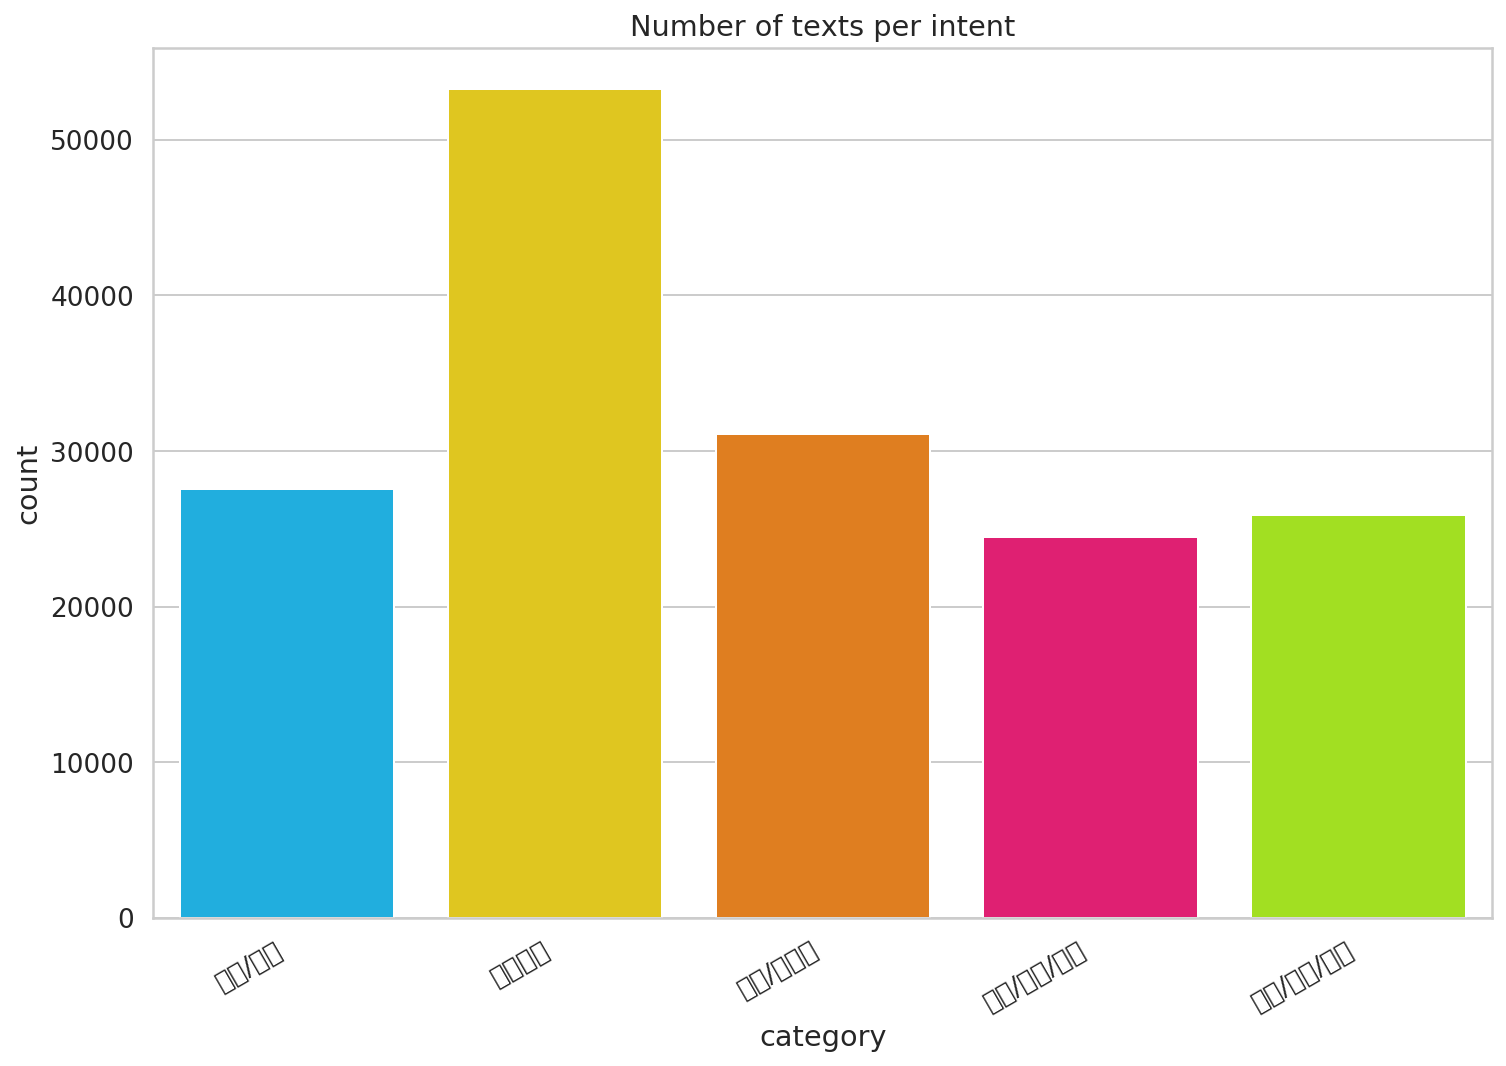

In [24]:
chart = sns.countplot(df.category, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [0]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [26]:
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2020-02-10 07:34:00--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip.1’

multi_cased_L-12_H- 100%[===================>] 632.19M   103MB/s    in 6.3s    

2020-02-10 07:34:06 (101 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip.1’ saved [662903077/662903077]



In [27]:
!unzip multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [0]:
os.makedirs("model", exist_ok=True)

In [29]:
!mv multi_cased_L-12_H-768_A-12/ model

mv: cannot move 'multi_cased_L-12_H-768_A-12/' to 'model/multi_cased_L-12_H-768_A-12': Directory not empty


In [0]:
bert_model_name="multi_cased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [0]:
class CategoryDetectionData:
  DATA_COLUMN = "petition_overview"
  LABEL_COLUMN = "category"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[CategoryDetectionData.DATA_COLUMN], row[CategoryDetectionData.LABEL_COLUMN]
      lst = kss.split_sentences(text)
      result = ["[SEP]"] * (len(lst) * 2 + 1)
      result[1::2] = lst
      result[0] = "[CLS]"
      sentence = ' '.join(result)
      tokens = self.tokenizer.tokenize(sentence)
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [0]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer =  hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1", 
                             trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [33]:
tokenizer.tokenize("봄이 오고있습니다.")

['봄', '##이', '오', '##고', '##있', '##습', '##니다', '.']

In [34]:
tokens = tokenizer.tokenize("봄이 오고있습니다.")
tokenizer.convert_tokens_to_ids(tokens)

[9360, 10739, 9580, 11664, 119192, 119081, 48345, 119]

In [0]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [36]:
classes = train.category.unique().tolist()

data = CategoryDetectionData(train, test, tokenizer, classes, max_seq_len=128)

129765it [04:04, 530.46it/s]
32510it [01:02, 519.76it/s]


max seq_len 66357


In [37]:
data.train_x.shape

(129765, 128)

In [38]:
data.train_x[0]

array([   164,  75151,  10731,    166,   9477, 119354,  17342,   9083,
        44359,  20309,  10530,  18154,   9672,  34951,  58303,  48345,
          119,    164,  23056,  11127,    166,  15361,  81456,  18392,
         9477, 119354,  17342,   9083,  44359,  20309,  11287,   9783,
       118937,  12453,    126,  89851,  93119,  11287,  66674,   9647,
       119081,  48345,    119,    164,  23056,  11127,    166,   9663,
        11018,   9604,  44130,   9004,  32537,   9641, 119246,   9928,
        12310,  11102,  27487,  63783,  11287,  23969,   9420,  66540,
        10622, 102838,   9647, 119081,  48345,    119,    164,  23056,
        11127,    166,  23289,    117,   9765,  31531,   9638,   9405,
        11664,  10530,  18154,   9994,  31503,  11102,   9960,  74322,
        10739,  39218,  14867,   8982,  81724,  11018,   9297,  36210,
        12030,   9670,  52961,   9798,  11903,  49919,   9365, 105462,
        10739,   9100,  69283,  77324,   9420,  66540,  10530,   9638,
      

In [39]:
data.train_y[0]

0

In [40]:
data.max_seq_len

128

In [41]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f9c83d598d0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [42]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3845  

In [0]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [0]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=1,
  callbacks=[tensorboard_callback]
)

Train on 116788 samples, validate on 12977 samples
 18512/116788 [===>..........................] - ETA: 1:52:04 - loss: 1.3317 - acc: 0.5656

In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir log

In [0]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [0]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [0]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

In [0]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [0]:
print(classification_report(data.test_y, y_pred, target_names=classes))

In [0]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

In [8]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

NameError: ignored